# Multi-sites

author: laquitainesteeve@gmail.com

Plot multi-channel spatio-temporal dynamics of action potentials

Execution time: 10 secs

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz)

Resources required:
- 180 GB RAM

## Setup

Prerequisites:

1. Setup "_envs/spikebias.yml_" virtual environment
2. Setup jupyter kernel _$python -m ipykernel install --user --name spikebias --display-name "spikebias"_
3. Download recordings: "_notebooks/0_download_recordings.ipynb_"


In [1]:
# listen to changes
%load_ext autoreload
%autoreload 2

import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np 
import spikeinterface as si
import yaml
import warnings
import spikeinterface.preprocessing as spre
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

# set project path
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)

# SETUP PARAMETERS
SAMPFREQ = 20000  # hz

# figure parameters
SAVE_FIG = True
LOAD_FIG_DATA = True

with open("./conf/figures.yml", "r", encoding="utf-8") as yaml_file:
    fig_data_paths = yaml.load(yaml_file, Loader=yaml.FullLoader)
    
# plot
PLOT_Y_PITCH = 500  # fixed distance between electrodes on plot for visibility
GAIN_TO_UV = 0.195
ylim = [-2111.4893, 691.5947]

DURATION = 10
NUM = 500
LINEWIDTH = 0.15
LINEWIDTH_BORD = 0.25
n_timepoints = int(DURATION * SAMPFREQ / 1000)

# FIGURE SETTINGS
COLOR_HS = np.array([26, 152, 80]) / 255 # green
LINEWIDTH = 0.5
LINEWIDTH_BORD = 0.25

# axes
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7
plt.rcParams["lines.linewidth"] = 0.5
plt.rcParams["axes.linewidth"] = 0.5  # 1
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5  # 0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5  # 0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5  # 0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5  # 0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1

# legend
savefig_cfg = {"transparent": True, "dpi": 300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False  # no legend frame

## L1,2/3

### Load dataset

In [2]:
%%time 

# load figure data
fig_data = np.load(fig_data_paths["fig2l_spacetime_custom_biophy_l1_2_3"], allow_pickle=True).item()        
print(fig_data_paths["fig2l_spacetime_custom_biophy_l1_2_3"])

dataset/02_figure_dataset/fig2l_spacetime_custom_biophy_l1_2_3.npy
CPU times: user 732 µs, sys: 0 ns, total: 732 µs
Wall time: 543 µs


In [3]:
# count site per column
site_per_col = int(len(fig_data["layers"]) / 4)

# get layers layout
col1_site_out = np.where(fig_data["layers"][:site_per_col] == "Outside")[0]
col1_site_l1 = np.where(fig_data["layers"][:site_per_col] == "L1")[0]
col1_site_l2_3 = np.where((fig_data["layers"][:site_per_col] == "L2_3"))[0]
col1_site_l4 = np.where(fig_data["layers"][:site_per_col] == "L4")[0]
col1_site_l5 = np.where(fig_data["layers"][:site_per_col] == "L5")[0]
col1_site_l6 = np.where(fig_data["layers"][:site_per_col] == "L6")[0]

# find common ylim to set all voltage traces to
ymax = fig_data["trace"][:, np.hstack([col1_site_l2_3, col1_site_l1])].max()
ymin = fig_data["trace"][:, np.hstack([col1_site_l2_3, col1_site_l1])].min()
print(ymax, ymin)

# scale voltage trace with Horvath gain
scaled = np.array(ylim)*GAIN_TO_UV
print("gain to uV:", scaled)

# report the voltage scale of all axes (the ylimits) 
print("the voltage scale of all plotted axes is:", np.round(scaled[1] - scaled[0]), "uV")

89.48747 -109.16937
gain to uV: [-411.7404135  134.8609665]
the voltage scale of all plotted axes is: 547.0 uV


number of sites shown: 26


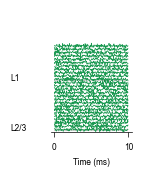

In [4]:
n_sites_l123 = len(col1_site_l1) + len(col1_site_l2_3)
fig_vert_size_l123 = 1.6

FIGSIZE = (1.05, fig_vert_size_l123)  # DO NOT CHANGE!! Calibrated for preprint figure

PLOT_Y_PITCH = 100
Y_MAX = PLOT_Y_PITCH * (site_per_col - 1)

# plot (0: bottom 96:top)
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
pos_up = 0
row = 0
c_site = 0

save_trace_data = []

for contact_i in np.arange(0, site_per_col, 1):
    # layer 2/3
    if contact_i == col1_site_l2_3[0]:
        ax.hlines(
            y=0.99 * pos_up,
            xmin=0,
            xmax=n_timepoints,
            color="black",
            linewidth=LINEWIDTH_BORD,
        )
        # label layer
        ax.text(
            # 610,
            -120,
            0.99 * pos_up,
            "%s" % ("L2/3"),
            size=plt.rcParams["font.size"],
            zorder=100,
            color="k",
            ha="left",
        )
    # layer 1
    if contact_i == col1_site_l1[0]:
        ax.hlines(
            y=0.99 * pos_up,
            xmin=0,
            xmax=n_timepoints,
            color="black",
            linewidth=LINEWIDTH_BORD,
        )
        # label layer
        ax.text(
            # 610,
            -120,
            0.99 * pos_up,
            "%s" % ("L1"),
            size=plt.rcParams["font.size"],
            zorder=100,
            color="k",
            ha="left",
        )

    # Outside
    if contact_i == 73:
        ax.hlines(
            y=pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=LINEWIDTH_BORD
        )

    # in target layer
    if contact_i in col1_site_l1:
        c_site += 1
        ax.plot(
            fig_data["trace"][:, contact_i] + pos_up,
            linewidth=LINEWIDTH,
            color=COLOR_HS,
        )
        pos_up += PLOT_Y_PITCH

        # record plotted traces
        save_trace_data.append(fig_data["trace"][:,contact_i])

    if contact_i in col1_site_l2_3:
        c_site += 1
        ax.plot(
            fig_data["trace"][:, contact_i] + pos_up,
            linewidth=LINEWIDTH,
            color=COLOR_HS,
        )
        pos_up += PLOT_Y_PITCH

        # record plotted traces
        save_trace_data.append(fig_data["trace"][:,contact_i])

ax.spines[["left", "right", "top"]].set_visible(False)
ax.set_xticks([0, n_timepoints])
ax.set_xticklabels([0, DURATION])
ax.set_xlabel("Time (ms)")
ax.set_ylim([-80, Y_MAX + 500])
plt.yticks([])

print("number of sites shown:", c_site)

number of sites shown: 26


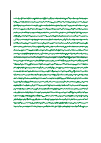

In [5]:
# setup plot
n_sites = len(col1_site_l1) + len(col1_site_l2_3)
fig, ax = plt.subplots(n_sites, 1, figsize=FIGSIZE)

# allow  vertical overlap of trace axes
fig.subplots_adjust(hspace=-0.9)                        

# delimit layer 4 and 5
sites = np.hstack([col1_site_l1, col1_site_l2_3])
l23_ix = np.where(sites == col1_site_l2_3[0])[0]

# plot electrode site voltage traces
for site in range(n_sites):
    flipped_site = n_sites-site-1
    ax[flipped_site].plot(save_trace_data[site], linewidth=LINEWIDTH, color=COLOR_HS)
    ax[flipped_site].set_ylim(ylim)
    ax[flipped_site].spines[["left", "right", "top","bottom"]].set_visible(False)
    ax[flipped_site].set_yticks([])
    ax[flipped_site].set_xticks([])
    ax[flipped_site].set_facecolor("none")   # transparent background

    # delimit sites from layer 4 and 5
    if site==l23_ix:
        ax[site].hlines(
            y=10,
            xmin=0,
            xmax=n_timepoints,
            color="black",
            linewidth=LINEWIDTH_BORD,
        )
print("number of sites shown:", n_sites)

# show voltage scale
ax[0].spines[["left"]].set_visible(True)

# save figures
if SAVE_FIG:
    plt.savefig(
        "figures/0_validation/2_dynamics/fig2l_spacetime_custom_biophy_l1_2_3.svg",
        **savefig_cfg
    )

## L4 and 5

### Load dataset

In [6]:
%%time 

# load figure data
fig_data = np.load(fig_data_paths["fig2l_spacetime_custom_biophy_l4_5"], allow_pickle=True).item()        

CPU times: user 660 µs, sys: 0 ns, total: 660 µs
Wall time: 414 µs


In [7]:
# count site per column
site_per_col = int(len(fig_data["layers"]) / 4)

# get layers layout
col1_site_out = np.where(fig_data["layers"][:site_per_col] == "Outside")[0]
col1_site_l1 = np.where(fig_data["layers"][:site_per_col] == "L1")[0]
col1_site_l2_3 = np.where((fig_data["layers"][:site_per_col] == "L2_3"))[0]
col1_site_l4 = np.where(fig_data["layers"][:site_per_col] == "L4")[0]
col1_site_l5 = np.where(fig_data["layers"][:site_per_col] == "L5")[0]
col1_site_l6 = np.where(fig_data["layers"][:site_per_col] == "L6")[0]

# find common ylim to set all voltage traces to
ymax = fig_data["trace"][:,np.hstack([col1_site_l4, col1_site_l5])].max()
ymin = fig_data["trace"][:,np.hstack([col1_site_l4, col1_site_l5])].min()
print(ymax, ymin)

691.5947 -2111.4893


number of sites shown: 31


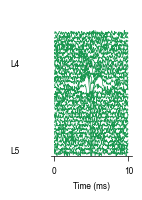

In [8]:
n_sites_l4_5 = len(col1_site_l4) + len(col1_site_l5)
keep_size_ratio = (n_sites_l4_5 * fig_vert_size_l123)/n_sites_l123

FIGSIZE = (1.05, keep_size_ratio)  # DO NOT CHANGE!! Calibrated for figure

Y_MAX = PLOT_Y_PITCH * (site_per_col - 1)

# plot (0: bottom 96:top)
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
pos_up = 0
row = 0
c_site = 0

save_trace_data = []

for contact_i in np.arange(0, site_per_col, 1):
    # layer 4
    if contact_i == col1_site_l4[0]:
        ax.hlines(
            y=0.99 * pos_up,
            xmin=0,
            xmax=n_timepoints,
            color="black",
            linewidth=LINEWIDTH_BORD,
        )
        # label layer
        ax.text(
            # 610,
            -120,
            0.99 * pos_up,
            "%s" % ("L4"),
            size=plt.rcParams["font.size"],
            zorder=100,
            color="k",
            ha="left",
        )
    # layer 5
    if contact_i == col1_site_l5[0]:
        ax.hlines(
            y=0.99 * pos_up,
            xmin=0,
            xmax=n_timepoints,
            color="black",
            linewidth=LINEWIDTH_BORD,
        )
        # label layer
        ax.text(
            # 610,
            -120,
            0.99 * pos_up,
            "%s" % ("L5"),
            size=plt.rcParams["font.size"],
            zorder=100,
            color="k",
            ha="left",
        )

    # Outside
    if contact_i == 73:
        ax.hlines(
            y=pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=LINEWIDTH_BORD
        )

    # in target layer
    if contact_i in col1_site_l4:
        c_site += 1
        ax.plot(
            fig_data["trace"][:, contact_i] + pos_up,
            linewidth=LINEWIDTH,
            color=COLOR_HS,
        )
        pos_up += PLOT_Y_PITCH

        # record plotted traces
        save_trace_data.append(fig_data["trace"][:,contact_i])

    if contact_i in col1_site_l5:
        c_site += 1
        ax.plot(
            fig_data["trace"][:, contact_i] + pos_up,
            linewidth=LINEWIDTH,
            color=COLOR_HS,
        )
        pos_up += PLOT_Y_PITCH

        # record plotted traces
        save_trace_data.append(fig_data["trace"][:,contact_i])

ax.spines[["left", "right", "top"]].set_visible(False)
ax.set_xticks([0, n_timepoints])
ax.set_xticklabels([0, DURATION])
ax.set_xlabel("Time (ms)")
ax.set_ylim([-80, Y_MAX + 500])
plt.yticks([])

print("number of sites shown:", c_site)


number of sites shown: 31


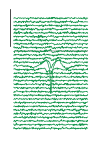

In [9]:
# setup plot
n_sites = len(col1_site_l4) + len(col1_site_l5)
fig, ax = plt.subplots(n_sites, 1, figsize=FIGSIZE)

# allow  vertical overlap of trace axes
fig.subplots_adjust(hspace=-0.9)                        

# delimit layer 4 and 5
sites = np.hstack([col1_site_l4, col1_site_l5])
l5_ix = np.where(sites == col1_site_l5[0])[0]

# plot electrode site voltage traces
for site in range(n_sites):
    flipped_site = n_sites-site-1
    ax[flipped_site].plot(save_trace_data[site], linewidth=LINEWIDTH, color=COLOR_HS)
    ax[flipped_site].set_ylim(ylim)
    ax[flipped_site].set_yticks([])
    ax[flipped_site].set_xticks([])
    ax[flipped_site].set_facecolor("none")   # transparent background
    ax[flipped_site].spines[["left", "right", "top","bottom"]].set_visible(False)

    # delimit sites from layer 4 and 5
    if site==l5_ix:
        ax[site].hlines(
            y=10,
            xmin=0,
            xmax=n_timepoints,
            color="black",
            linewidth=LINEWIDTH_BORD,
        )
print("number of sites shown:", n_sites)

# show voltage scale (ymin and ymax voltage)
ax[0].spines[["left"]].set_visible(True)

# save figures
if SAVE_FIG:
    plt.savefig(
        "figures/0_validation/2_dynamics/fig2l_spacetime_custom_biophy_l4_5.svg",
        **savefig_cfg
    )

## L6

In [10]:
%%time 

# load figure data
fig_data = np.load(fig_data_paths["fig2l_spacetime_custom_biophy_l6"], allow_pickle=True).item()        
print(fig_data_paths["fig2l_spacetime_custom_biophy_l6"])

dataset/02_figure_dataset/fig2l_spacetime_custom_biophy_l6.npy
CPU times: user 0 ns, sys: 645 µs, total: 645 µs
Wall time: 532 µs


In [11]:
# count the number of sites per column
site_per_col = int(len(fig_data['layers']) / 4)
col1_site_out = np.where(fig_data['layers'][:site_per_col] == "Outside")[0]
col1_site_l6 = np.where(fig_data['layers'][:site_per_col] == "L6")[0]

# find common ylim to set all voltage traces to
ymax = fig_data["trace"][:, col1_site_l6].max()
ymin = fig_data["trace"][:, col1_site_l6].min()
print(ymax, ymin)

155.12364 -144.46158


number of sites shown: 19


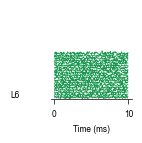

In [12]:
n_sites_l6 = len(col1_site_l6)
keep_size_ratio = (n_sites_l6 * fig_vert_size_l123)/n_sites_l123
FIGSIZE = (1.05, keep_size_ratio)  # DO NOT CHANGE!! Calibrated for figure

Y_MAX = PLOT_Y_PITCH * (site_per_col - 1)

# plot (0: bottom 96:top)
fig, ax = plt.subplots(1, 1, figsize=FIGSIZE)
pos_up = 0
row = 0
c_site = 0

# record plotted traces
save_trace_data = []

for contact_i in np.arange(0, site_per_col, 1):
    # layer 6
    if contact_i == col1_site_l6[0]:
        ax.hlines(
            y=0.99 * pos_up,
            xmin=0,
            xmax=n_timepoints,
            color="black",
            linewidth=LINEWIDTH_BORD,
        )
        # label layer
        ax.text(
            # 610,
            -120,
            0.99 * pos_up,
            "%s" % ("L6"),
            size=plt.rcParams["font.size"],
            zorder=100,
            color="k",
            ha="left",
        )

    # Outside
    if contact_i == 73:
        ax.hlines(
            y=pos_up, xmin=0, xmax=n_timepoints, color="black", linewidth=LINEWIDTH_BORD
        )

    # in target layer
    if contact_i in col1_site_l6:
        c_site += 1
        ax.plot(
            fig_data['trace'][:, contact_i] + pos_up,
            linewidth=LINEWIDTH,
            color=COLOR_HS,
        )
        pos_up += PLOT_Y_PITCH

        # record plotted traces
        save_trace_data.append(fig_data["trace"][:,contact_i])

# legend
ax.spines[["left", "right", "top"]].set_visible(False)
ax.set_xticks([0, n_timepoints])
ax.set_xticklabels([0, DURATION])
ax.set_xlabel("Time (ms)")
ax.set_ylim([-80, Y_MAX + 500])
plt.yticks([])

print("number of sites shown:", c_site)

# save figures
if SAVE_FIG:
    plt.savefig(
        "figures/0_validation/2_dynamics/fig2l_spacetime_custom_biophy_l6.svg",
        **savefig_cfg
    )

number of sites shown: 19


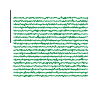

In [13]:
# make sure all voltage traces are on the same voltage scale
# setup plot
n_sites = len(col1_site_l6)
fig, ax = plt.subplots(n_sites, 1, figsize=FIGSIZE)

# allow  vertical overlap of trace axes
fig.subplots_adjust(hspace=-0.9)                        

# plot electrode site voltage traces
for site in range(n_sites):
    flipped_site = n_sites-site-1
    ax[flipped_site].plot(save_trace_data[site], linewidth=LINEWIDTH, color=COLOR_HS)
    ax[flipped_site].set_ylim(ylim)
    ax[flipped_site].set_yticks([])
    ax[flipped_site].set_xticks([])
    ax[flipped_site].set_facecolor("none")   # transparent background
    ax[flipped_site].spines[["left", "right", "top", "bottom"]].set_visible(False)

# show voltage scale
ax[0].spines[["left"]].set_visible(True)

print("number of sites shown:", n_sites)

# save figures
if SAVE_FIG:
    plt.savefig(
        "figures/0_validation/2_dynamics/fig2l_spacetime_custom_biophy_l6.svg",
        **savefig_cfg
    )